In [1]:
from sklearn.decomposition import FastICA, PCA
from sklearn.cross_decomposition import PLSRegression


import logging
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

from pathlib import Path

import seaborn as sns

from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics


from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import PredictionErrorDisplay



In [2]:
df1 = pd.read_csv('/Users/AdrianHanson/Downloads/JointMatrix-HumanBloodFrailty85-HumanBloodKidneyTrans68-preTransplant_PCA_allTraits_20230419.tsv', sep='\t', header=0)
df2 = pd.read_csv('/Users/AdrianHanson/Downloads/JointMethMatrixCG-HumanBloodFrailty85-HumanBloodKidneyTrans68-preTransplant_20-100 (1).tsv', sep='\t', header=0)

traits = df1.set_index("Samples")
methRaw = df2.set_index("Samples")

traits = traits.drop(labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], axis = 1)


logger = logging.getLogger('icasso')


In [3]:
display(traits)

Bcell  NaiveT  NKcell  Monocyte  NeutrophilBand   Tcell    age  \
Samples                                                                        
Kidney_1354  0.1227  0.2563  0.0328    0.0860          0.0482  0.4753  22.76   
Kidney_1400  0.1052  0.1133  0.0602    0.0857          0.2118  0.4277  30.53   
Kidney_1410  0.1030  0.1206  0.0981    0.1715          0.0000  0.5292  34.51   
Kidney_1415  0.0908  0.0955  0.1994    0.2974          0.0000  0.3265  68.68   
Kidney_1417  0.0772  0.0661  0.0500    0.3947          0.0000  0.4235  40.77   
...             ...     ...     ...       ...             ...     ...    ...   
Lung_190067  0.2064  0.0421  0.2497    0.0581          0.0391  0.3931  69.13   
Lung_190071  0.0482  0.0736  0.0509    0.6795          0.1126  0.0550  43.46   
Lung_190098  0.0675  0.0183  0.1498    0.2232          0.0080  0.5598  63.38   
Lung_200006  0.1768  0.0682  0.0602    0.0939          0.0756  0.5577  64.22   
Lung_200029  0.0787  0.1079  0.1118    0.3988          0.1726  0.1780  35.09   

             sex  cmv_status  tissue  numericalRace  
Samples                                              
Kidney_1354    0           1       1              2  
Kidney_1400    0           1       1              0  
Kidney_1410    1           1       1              5  
Kidney_1415    1           1       1              4  
Kidney_1417    0           1       1              4  
...          ...         ...     ...            ...  
Lung_190067    0           0       0              1  
Lung_190071    0           1       0              1  
Lung_190098    1           1       0              5  
Lung_200006    0           1       0              1  
Lung_200029    0           0       0              2  

[153 rows x 11 columns]

In [4]:
class Icasso:
    def __init__(self, iterations= 5, n_components = 15):
        self.component_storage = []
        self._iterations = iterations   
        self._clusters = []
        self._dissim = []
        self._sim = []
        self._centrotypes = []
        self._centrotype_index = []
        self._unmixing_matrices = []
        self._n_components = n_components
        self._meth_data = None
    
        
    def icassoEst(self, meth_data, seed= 154):
        
        self._meth_data = pd.DataFrame(meth_data)
        n_components = self._n_components
        init_ica = FastICA(n_components= n_components , whiten="arbitrary-variance", random_state= seed)
#         init_ica = FastICA(n_components= n_components , whiten="arbitrary-variance")
        init_fit = init_ica.fit(meth_data)
        init_unmixing = init_ica.components_
        init_unmixing = pd.DataFrame(init_unmixing)
        self._unmixing_matrices.append(init_unmixing)
        init_transform = init_fit.transform(meth_data)
        
        
        components = init_transform
        
#         print(self._iterations)

        #generates a list of ICA runs with different initial conditions
        for i in range(1,self._iterations):
            seed_iter = seed + (i+1)*12
            ica = FastICA(n_components= n_components , whiten="arbitrary-variance", random_state= seed_iter)
#             ica = FastICA(n_components= n_components , whiten="arbitrary-variance")
            ica_fit = ica.fit(meth_data)
            get_unmixing = ica_fit.components_
            get_unmixing = pd.DataFrame(get_unmixing)
            self._unmixing_matrices.append(get_unmixing)
            ica_transform = ica_fit.transform(meth_data)
            
            components = np.concatenate((components, ica_transform), axis= 1)

        self.component_storage= components 
     
            
        #returns list of ICA runs
        return components   
           
    def icassoExp(self, n_clusters= 5, sign= 0):
        ##sign will correspond to the signs of the weights. If sign is 0, all weights will be included.
        ## If sign is -1 only negative values will be included, if sign is +1 then only positive weights will be included.
        
      
        
        components= self.component_storage
        #display components
        componentsDF = pd.DataFrame(components)
        display(componentsDF)
        
        rows, columns = components.shape
        
#         if sign == -1:
#             for i in range(0, columns):
#                 for j in range(0, rows):
#                     if components[j,i] > 0:
#                         components[j,i] = 0
        
#         if sign == 1:
#             for i in range(0, columns):
#                 for j in range(0, rows):
#                     if components[j,i] < 0:
#                         components[j,i] = 0
       
            
                    
                    
                    
        
        #calculate similarity
        sim = np.abs(np.corrcoef(components,rowvar= False))
        
        #calculate dissimilarity
        dissim = 1 - sim
        dissimDF = pd.DataFrame(dissim)
        #display(dissimDF)
        
        #Calculate cluster linkage from dissimilarity matrix
        clusters = linkage(squareform(dissim, checks=False), method='average')
        
        #look at clusters
        clusterDF= pd.DataFrame(clusters)
        #display(clusterDF)
    
        self._clusters = clusters
        self._sim = sim
        self._dissim = dissim
        
        return clusters
        
        
        
    def icassoDendrogram(self):
        
        clusters = self._clusters
        
        dendrogram(
            clusters,
            leaf_rotation=90.,
            leaf_font_size=1.,
            show_leaf_counts=True,
            no_labels=True)
        plt.show()
        
        return self
    


    def get_centrotype_unmixing(self, distance=0.8, unstable_thresh= 0):
        
        clusters_by_components = fcluster(self._clusters, distance, criterion='distance')
    
        #look at clusters_by_components
        clusters_by_components_DF= pd.DataFrame(clusters_by_components)
        #display(clusters_by_components_DF)

        components_by_clusters = self._get_components_by_clusters(
            clusters_by_components)
        scores = self._get_scores(components_by_clusters)
        similarities = self._sim
        
        
        components_by_clusters_DF = pd.DataFrame(components_by_clusters)
        
#         print("components by clusters")
#         display(components_by_clusters_DF)
        
        
        centrotypes = []
        centrotype_idx = []
        for cluster in components_by_clusters:
            centrotype = None
            max_simsum = None
            index = None
            for component_idx in cluster:
                simsum = sum([similarities[component_idx, other_idx] for
                              other_idx in cluster])
                #check if it is constantly increasing
                #print(simsum, component_idx)
                if max_simsum is None or simsum > max_simsum:
                    max_simsum = simsum
                    centrotype = self.component_storage[:,component_idx]
                    index = component_idx
                    

            centrotypes.append(centrotype)
            centrotype_idx.append(index)
            
            
        centrotype_arr = np.array(centrotypes).T
        centrotypeDF= pd.DataFrame(centrotype_arr)
#         display(centrotypeDF)

        self._centrotypes = centrotypeDF
        self._centrotype_index = centrotype_idx
        
   
        
        unmixing_matrix = np.array([centrotype for centrotype, _ in
                                    sorted(zip(centrotypes, scores),
                                           key=lambda x: x[1])])
        
        fig = plt.figure(figsize=(5, 5))
        for i in range(0, len(scores)): 
            plt.scatter(scores[i], i, label = i)
            plt.annotate(text= i, xy= (scores[i], i), xytext= (scores[i]+.008, i+.008))
        plt.xlabel("cluster quality")
        plt.ylabel("cluster number")

        unstable_components = []
        for j in range(0, len(scores)):
            if scores[j] < unstable_thresh:
                unstable_components.append(j)
                print(j)
              

            
        
        return unmixing_matrix[::-1, :], sorted(scores)[::-1], unstable_components

    def _get_components_by_clusters(self, clusters_by_components):
        """ Converts clusters-by-components representation to
        components-by-clusters """
        components_by_clusters = {}
        for comp_idx, cluster_id in enumerate(clusters_by_components):
            if cluster_id not in components_by_clusters:
                components_by_clusters[cluster_id] = []
            components_by_clusters[cluster_id].append(comp_idx)
        components_by_clusters = sorted(components_by_clusters.items(),
                                        key=lambda x: x[0])
        components_by_clusters = [val for key, val in components_by_clusters]
        
        components_by_clusters_DF = pd.DataFrame(components_by_clusters)
        #display(components_by_clusters_DF)
        
        return components_by_clusters

    def _get_scores(self, components_by_clusters):
        """ Calculate quality index for compactness
        and isolation """
        similarities = self._sim
        scores = []

        for idx, cluster in enumerate(components_by_clusters):
            other_clusters = components_by_clusters[:idx] + \
                components_by_clusters[idx+1:]
            other_components = [
                comp for cluster_ in other_clusters for comp in cluster_]
            within_sum = sum([similarities[ii, jj]
                              for ii in cluster for jj in cluster])
            within_similarity = (1.0/len(cluster)**2)*within_sum
            between_sum = sum([similarities[ii, jj]
                               for ii in cluster for jj in other_components])
            between_similarity = (
                1.0/(len(cluster)*len(other_components)))*between_sum
            scores.append(within_similarity - between_similarity)

        return scores
        
    def _trait_correlation(self, traitMatrix, methMatrix, unstable_components= [], sign= 0):
        if traitMatrix is not pd.DataFrame():
            traitMatrix = pd.DataFrame(traitMatrix)
            
        if methMatrix is not pd.DataFrame():
            methMatrix = pd.DataFrame(methMatrix)
        
    
        
        scaled_traits = pd.DataFrame(StandardScaler().fit_transform(traitMatrix),index= traitMatrix.index, columns= traitMatrix.columns)
        
        stable_IC = self._centrotypes.drop(unstable_components,axis = 1)
        
        
        rows, columns = stable_IC.shape
        
        if sign == -1:
            for i in range(0, columns):
                for j in range(0, rows):
                    if stable_IC.iloc[j,i] > 0:
                        stable_IC.iloc[j,i] = 0
        
        if sign == 1:
            for i in range(0, columns):
                for j in range(0, rows):
                    if stable_IC.iloc[j,i] < 0:
                        stable_IC.iloc[j,i] = 0
  
        stable_IC.index = scaled_traits.index
        
        print("stable_IC")
        display(stable_IC)
        
        join_traits = stable_IC.join(scaled_traits)
                
        trait_corr= join_traits.corr(method = 'pearson')
        trait_corr= trait_corr.drop(columns = trait_corr.iloc[:,:stable_IC.shape[1]])
        trait_corr= trait_corr.drop(index = trait_corr.iloc[:stable_IC.shape[1], :])
        
          #create names for index
        for num in trait_corr.index:
            label = "IC" + str(num)
            trait_corr.rename(index = {num : label}, inplace= True)
        
        fig = plt.figure(figsize=(6, 3))
        
        sns.heatmap(trait_corr, cmap= 'flare', annot = True, fmt = ".2F")
        
        return stable_IC
        
        #Retrieve weights from mixing matrix to find site contribution
        
    def _get_stable_unmixing(self, unstable_components = []):
        centrotype_index = self._centrotype_index
        iterations = self._iterations
        unmixing_matrices = self._unmixing_matrices
        n_components = self._n_components
        component_arr = pd.DataFrame(self.component_storage)     
        
        print("there are ", len(unmixing_matrices), " unmixing matrices")
#         print("the last one is: ")
#         display(unmixing_matrices[9])
        
        
        relative_comp = []
        centrotype_unmixing = []
        for component in range (0,n_components):
            for it in range(0, iterations):
                if centrotype_index[component] >= it * n_components and centrotype_index[component] < (it + 1) * n_components:
                    relative_comp.append((centrotype_index[component] - (it * n_components), it))
                    temp_comp = centrotype_index[component] - (it * n_components)
                    it_unmixing = unmixing_matrices[it]
                    centrotype_unmixing.append(it_unmixing.iloc[temp_comp])
                    break

        print("relative component, iteration")
        for i in relative_comp:
            print(i)

        centrotype_unmixing = pd.DataFrame(np.array(centrotype_unmixing))
        
        centrotype_unmixing.drop(unstable_components, axis=0 ,inplace= True)
        
        centrotype_unmixing.columns = self._meth_data.columns
        
        #create names for index
        for num in centrotype_unmixing.index:
            label = "IC" + str(num)
            centrotype_unmixing.rename(index = {num : label}, inplace= True)
        
        

        
        print("unmixing weights by stable IC")
        display(centrotype_unmixing)
        
        return centrotype_unmixing
    
    
    def _site_contribution(self, unmixing_matrix, component, influence_thresh = 0.001, sign= 0):
        if unmixing_matrix is not pd.DataFrame():
            unmixing_matrix = pd.DataFrame(unmixing_matrix)
        
        contributing_sites = {}
        site_names = []
        
        
        print("unmixing matrix is ", len(unmixing_matrix.columns), " long")
        
        for site in range(0,len(unmixing_matrix.columns)):
            if sign == 1:
                if unmixing_matrix.iat[component, site] >= influence_thresh: 
                    contributing_sites.update({unmixing_matrix.columns[site]: unmixing_matrix.iat[component, site]})
                    site_names.append(unmixing_matrix.columns[site])
            elif sign == -1:
                if unmixing_matrix.iat[component, site] <= -influence_thresh: 
                    contributing_sites.update({unmixing_matrix.columns[site]: unmixing_matrix.iat[component, site]})
                    site_names.append(unmixing_matrix.columns[site])
                    
            else:
                if unmixing_matrix.iat[component, site] >= influence_thresh or unmixing_matrix.iat[component, site] <= -influence_thresh: 
                    contributing_sites.update({unmixing_matrix.columns[site]: unmixing_matrix.iat[component, site]})
                    site_names.append(unmixing_matrix.columns[site])
            
#         print("There are ", len(contributing_sites.keys()), " sites with weight ", influence_thresh, " or greater" )
#         for site in contributing_sites:
#             print(site, " : ", contributing_sites[site])
        
        
        return contributing_sites, site_names
        
        
        
          
        
            
        
        
        


        
        
        
        
        
        
        
        
        
        
        
        
        

In [5]:
#non member functions

def _is_it_a_boy(contrib_dic = {}):
    count = 0
    for key in contrib_dic:
        if "X" in key:
            count += 1
    
    print(count, " / ", len(contrib_dic.keys()), "are on the X chromosome")
    
    
    
def _make_bed(sites = []):
    
    test_split = sites[0].split("_")
    print(type(int(test_split[1])))
    
    count = 0
    bed = []
    for site in sites:
        bed_split = site.split("_")
        chrom_end = int(bed_split[1])
        chrom_end += 1
        bed.append([bed_split[0], bed_split[1], str(chrom_end)])
        count += 1
    
    bed = pd.DataFrame(bed)
    display(bed)
    
    file_path = Path('/Users/AdrianHanson/Desktop/Lab Files/Cistrome-GO/ICA contributions/Positive/IC 8/ICA_IC8_HumanBloodFrailty_thresh002_pos.csv')
    bed.to_csv(path_or_buf = file_path, sep='\t', index=False)
#     for values in bed:
#         print(values)
    return 0
    
    
    
    
    
    
    
    

In [6]:
def regression_model(features, responses, name):
   

     
    
#     find_alpha = lassoCV.fit(X,y)
    
#     print("cross validation alpha")
#     CValpha = find_alpha.alpha_
#     print(CValpha)
    
    
    #Use this alpha on the train-test split and see what happens
    
#     reg = Lasso(CValpha)
    
#     X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)
    
#     X_train_DF= pd.DataFrame(X_train)
#     display(X_train_DF)

    X = features
    y = responses
    
#     X = pd.DataFrame(X)
#     y = pd.DataFrame(y)
    
    #MSE 
    # create loocv procedure
    cv = LeaveOneOut()
    # create model
    model = LassoCV(random_state= 42)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force positive
    scores = absolute(scores)
    # report performance
    print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    
    #compute R^2
    
    ypreds = []
    ytests = []
    X_array = np.array(X)
    y_array = np.array(y)

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X_array[train_idx], X_array[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]
        
        r2model = LassoCV(random_state= 42)
        
        r2model.fit(X = X_train, y = y_train)
        y_pred = r2model.predict(X_test)
        
        ypreds += list(y_pred)
        ytests += list(y_test)
  

    r2 = metrics.r2_score(ytests, ypreds)
    
    print("R^2: ", r2)
    
    
    #MSE Graph
    plt.figure()
    plt.xlabel("α")
    plt.ylabel("MSE")
    plt.title(name)
    
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X_array[train_idx], X_array[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        MSEmodel = LassoCV(random_state= 42)    

        MSEmodel.fit(X = X_train, y = y_train)

        
        plt.semilogx(MSEmodel.alphas_, MSEmodel.mse_path_, linestyle=":")


        
            
            
            
            
            
    
#     reg.fit(X_train, y_train)
    
#     score = reg.score(X_test, y_test)
#     print("R^2 score is: ", score)
    
#     predictions = reg.predict(X_test)
    
#     print("x_train shape: ", X_train.shape)
#     print("y_train shape: ", y_train.shape)
    
#     print("x_test shape: ", X_test.shape)
#     print("prediction shape: ", predictions.shape)
    
    
#     mse = mean_squared_error(y_test, predictions)
#     rmse = mean_squared_error(y_test, predictions, squared= False)
    
#     print("MSE is: ", mse)
    
#     print("RMSE is:", rmse)
    
    return scores
    
    

    
    
    

In [7]:
#PCA Comparison 

def PCA_regression(meth_matrix, responses, name):
    pca_preprocess = PCA(n_components = 11)
    
    #normalize the methylation matrix
    scaled_meth = pd.DataFrame(StandardScaler().fit_transform(meth_matrix),index= meth_matrix.index, columns= meth_matrix.columns)

    #fit data
    pca = pca_preprocess.fit_transform(scaled_meth)
    
    #create linear model
    
    X = pca
    y = np.ravel(responses)
    
#     X = pd.DataFrame(X)
#     y = pd.DataFrame(y)
    
    #MSE 
    # create loocv procedure
    cv = LeaveOneOut()
    # create model
    model = LassoCV(random_state= 42)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force positive
    scores = absolute(scores)
    # report performance
    print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    
    #compute R^2
    
    ypreds = []
    ytests = []
    X_array = np.array(X)
    y_array = np.array(y)

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X_array[train_idx], X_array[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]
        
        r2model = LassoCV(random_state= 42)
        
        r2model.fit(X = X_train, y = y_train)
        y_pred = r2model.predict(X_test)
        
        ypreds += list(y_pred)
        ytests += list(y_test)
  

    r2 = metrics.r2_score(ytests, ypreds)
    
    print("R^2: ", r2)
    
    
    #MSE Graph
    plt.figure()
    plt.xlabel("α")
    plt.ylabel("MSE")
    plt.title(name)
    
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X_array[train_idx], X_array[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        MSEmodel = LassoCV(random_state= 42)    

        MSEmodel.fit(X = X_train, y = y_train)

        
        plt.semilogx(MSEmodel.alphas_, MSEmodel.mse_path_, linestyle=":")
    
    

# response = traits['NeutrophilBand']    
# response = pd.DataFrame(response)
# display(response)


# PCA_regression(meth_matrix = methRaw, responses = response, name = 'Neutraphil Band')
    
    

PCA Lasso
Bcell
MAE: 0.025 (0.019)
R^2:  0.8459576283055719
NaiveT
MAE: 0.044 (0.037)
R^2:  0.6643019878360565
NKcell
MAE: 0.037 (0.035)
R^2:  0.6172299415607632
Monocyte
MAE: 0.065 (0.054)
R^2:  0.6052026718008596
NeutrophilBand
MAE: 0.049 (0.050)
R^2:  0.6645755861387489
Tcell
MAE: 0.072 (0.054)
R^2:  0.7403967766368006
age
MAE: 6.047 (6.091)
R^2:  0.5431967434998759
sex
MAE: 0.127 (0.088)
R^2:  0.9049801120715184
cmv_status
MAE: 0.455 (0.158)
R^2:  -0.006454406464139861
tissue
MAE: 0.136 (0.188)
R^2:  0.7822892542687838
numericalRace
MAE: 1.167 (0.638)
R^2:  0.2186889884676888


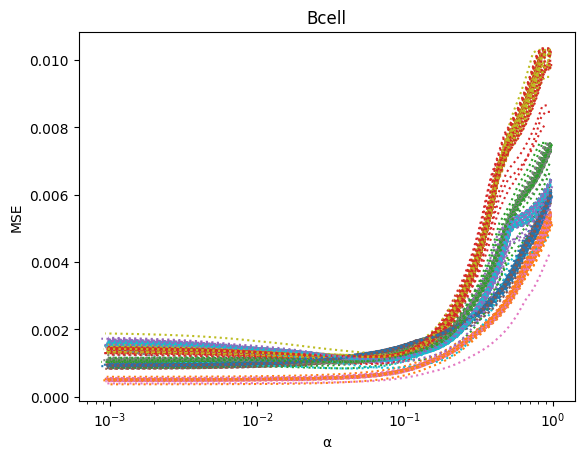

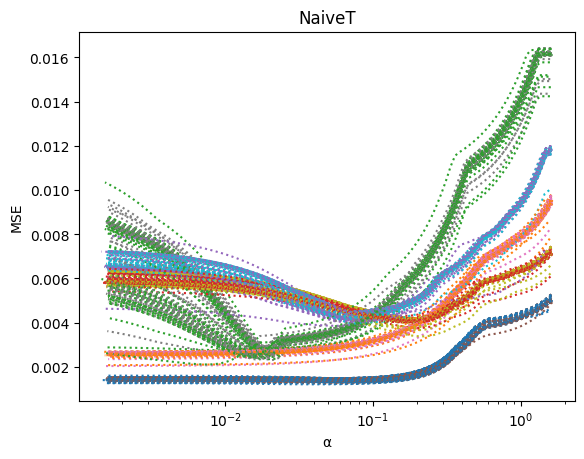

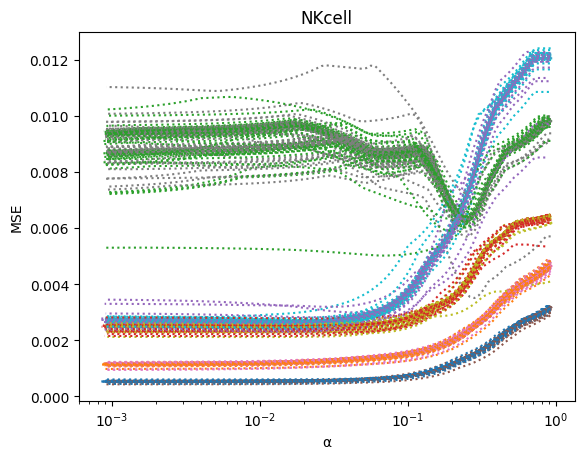

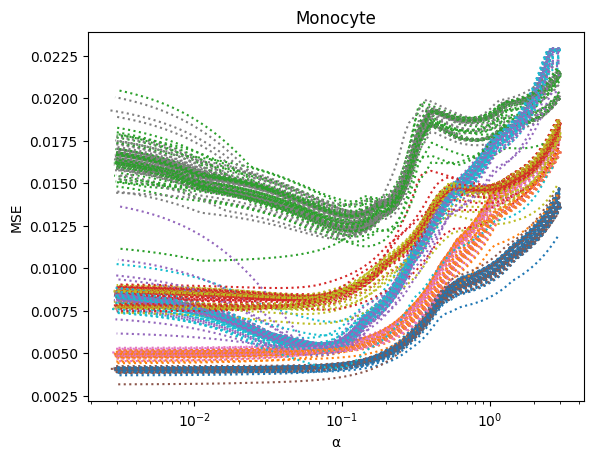

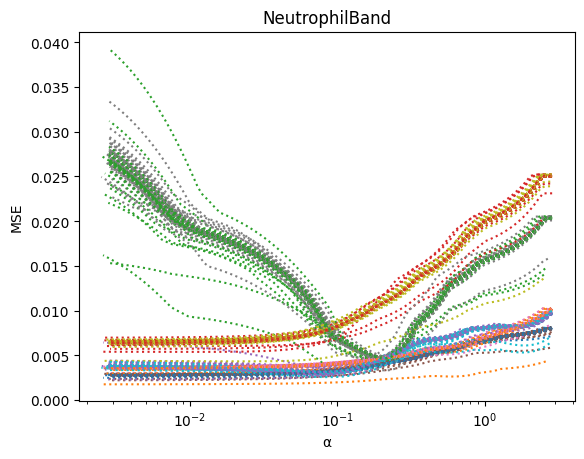

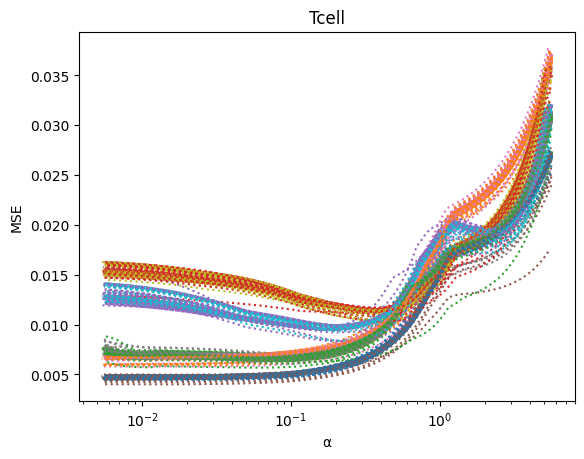

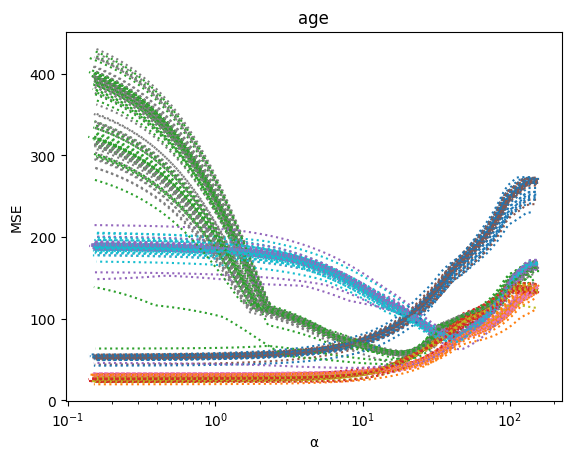

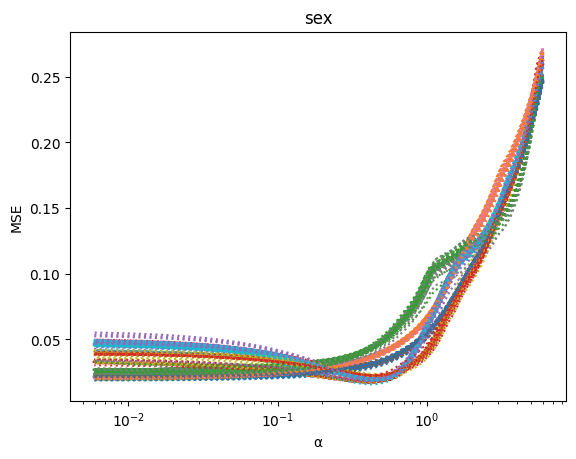

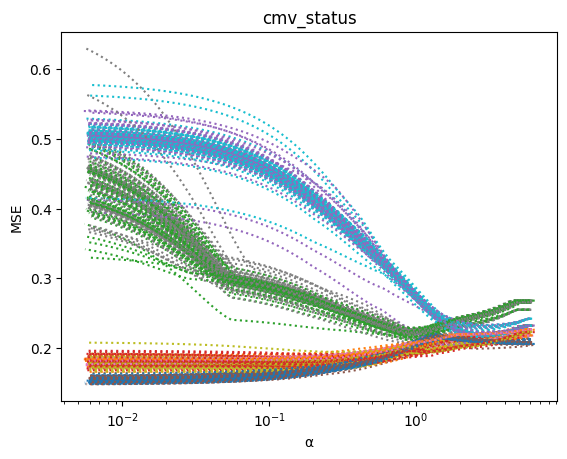

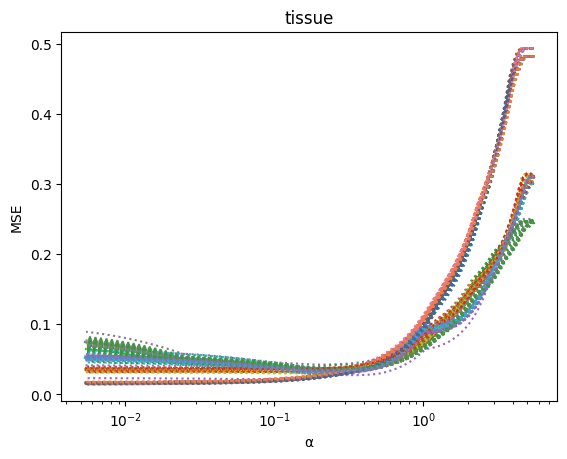

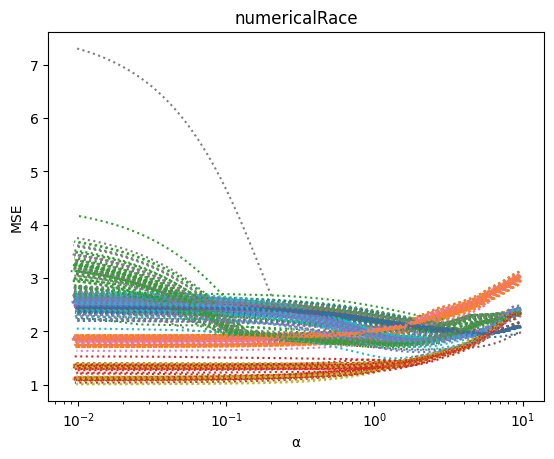

In [8]:
print("PCA Lasso")

for i in traits:
    y_trait = traits[i]
    X_train = methRaw
    
    print(i)
    
    PCA_regression(X_train, y_trait, i)


In [9]:
def PLS(meth_matrix, responses, name):
    
    #scaled_meth = pd.DataFrame(StandardScaler().fit_transform(meth_matrix),index= meth_matrix.index, columns= meth_matrix.columns)

    #fit data
    
 
    
    #create linear model
    
    X = meth_matrix
    y = np.ravel(responses)
    
#     X = pd.DataFrame(X)
#     y = pd.DataFrame(y)
    
    #MSE 
    # create loocv procedure
    cv = LeaveOneOut()
    # create model
    model = PLSRegression(n_components = 11)    # evaluate model
    MAE_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force positive
    scores = absolute(MAE_scores)
    # report performance
    print('MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    
    
#     compute R^2

    ypreds = []
    ytests = []
    X_array = np.array(X)
    y_array = np.array(y)

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X_array[train_idx], X_array[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]
        
        r2model = model
        
        r2model.fit(X = X_train, Y = y_train)
        y_pred = r2model.predict(X_test)
        
        ypreds += list(y_pred)
        ytests += list(y_test)
  

    r2 = metrics.r2_score(ytests, ypreds)
    
    print("R^2: ", r2)
    
    

In [10]:
print("PLS")

for i in traits:
    y_trait = traits[i]
    X_train = methRaw
    
    print(i)
    
    PLS(X_train, y_trait, i)


PLS
Bcell
MAE: 0.025 (0.020)
R^2:  0.8431426032522779
NaiveT
MAE: 0.041 (0.035)
R^2:  0.7048917099048826
NKcell
MAE: 0.032 (0.031)
R^2:  0.7094772577517978
Monocyte
MAE: 0.051 (0.043)
R^2:  0.7541536632854322
NeutrophilBand
MAE: 0.037 (0.035)
R^2:  0.8209047459234997
Tcell
MAE: 0.069 (0.056)
R^2:  0.7480426312414403
age
MAE: 3.899 (2.976)
R^2:  0.8508243598243626
sex
MAE: 0.136 (0.064)
R^2:  0.9091926507204486
cmv_status
MAE: 0.382 (0.224)
R^2:  0.1478748210200993
tissue
MAE: 0.137 (0.082)
R^2:  0.8963849231510427
numericalRace
MAE: 1.048 (0.620)
R^2:  0.34439233599760166


0         1         2         3         4         5         6    \
0    0.002542 -0.084886 -0.008983 -0.023601  0.082000  0.034223  0.046852   
1   -0.047796  0.031297 -0.040742 -0.023035  0.074573  0.006762 -0.037638   
2   -0.016773  0.004242 -0.003852 -0.002234 -0.084269  0.048189 -0.004692   
3   -0.028413  0.104315 -0.053062  0.062667 -0.160873  0.059411  0.061863   
4   -0.018749  0.051243 -0.061785  0.024245  0.003085 -0.013879  0.050599   
..        ...       ...       ...       ...       ...       ...       ...   
148  0.028988  0.009019  0.823389  0.036243  0.002272  0.007093  0.019025   
149  0.071985  0.022936  0.003374  0.058489  0.033876  0.004416 -0.039134   
150 -0.095114 -0.020396 -0.077621  0.036888 -0.182384  0.043886 -0.008418   
151 -0.005315  0.020706  0.050084  0.005619 -0.015527 -0.015148  0.004622   
152  0.044038 -0.114733 -0.052185  0.018072 -0.067284 -0.166482 -0.035429   

          7         8         9    ...       190       191       192  \
0    0.025877  0.000890 -0.007102  ...  0.089539 -0.076432 -0.029442   
1    0.075818 -0.009816  0.016214  ...  0.079758 -0.111393  0.043198   
2    0.243325 -0.070639  0.081954  ... -0.072769  0.071095 -0.018747   
3    0.016740  0.035389 -0.110573  ... -0.158899  0.071027 -0.044483   
4   -0.007316  0.007775  0.010455  ... -0.000187 -0.087114 -0.071470   
..        ...       ...       ...  ...       ...       ...       ...   
148  0.011155  0.015617 -0.019850  ...  0.000206 -0.014894 -0.005327   
149 -0.068542  0.067522  0.086892  ...  0.039027 -0.040103  0.046826   
150  0.238177  0.017747  0.048416  ... -0.168098  0.033665  0.029366   
151 -0.226497 -0.076700  0.043093  ... -0.015730 -0.016654 -0.004473   
152 -0.163940  0.055456 -0.097675  ... -0.078110 -0.013575  0.042729   

          193       194       195       196       197       198       199  
0    0.001164 -0.035065 -0.004290  0.008629 -0.037521 -0.014706 -0.054143  
1    0.043188 -0.042487  0.035646  0.040222  0.038454 -0.030538  0.018046  
2    0.007223 -0.003575  0.000594  0.003305 -0.028643 -0.014105 -0.020592  
3    0.021561 -0.113178 -0.075389  0.054544  0.011189  0.066313 -0.011861  
4    0.014375 -0.201996 -0.041993  0.062919 -0.005696 -0.035821 -0.028398  
..        ...       ...       ...       ...       ...       ...       ...  
148 -0.033842  0.045039 -0.014920 -0.823498 -0.012369  0.001532 -0.008089  
149 -0.093421 -0.127057  0.028002  0.002653 -0.028933  0.008984 -0.059745  
150  0.080706  0.065204 -0.014360  0.077455 -0.040651  0.023398 -0.032118  
151  0.030008  0.116257  0.062584 -0.047832  0.000470 -0.073604 -0.128976  
152 -0.038877 -0.030241  0.234134  0.056010 -0.097926 -0.007177 -0.253452  

[153 rows x 200 columns]

12
13
14
15
16
17
18
19
stable_IC


0         1         2         3         4         5   \
Samples                                                                   
Kidney_1354 -0.041604  0.023128  0.008357  0.005020 -0.032390 -0.077164   
Kidney_1400 -0.015368  0.022979  0.040635 -0.016793  0.040997 -0.113742   
Kidney_1410 -0.024035  0.004922  0.002709 -0.085047 -0.031196  0.066228   
Kidney_1415  0.020850 -0.063850  0.052443  0.105758  0.012886  0.075947   
Kidney_1417 -0.013036 -0.026920  0.061569 -0.011606 -0.001039 -0.086869   
...               ...       ...       ...       ...       ...       ...   
Lung_190067  0.007145 -0.035494 -0.822835  0.019447 -0.014381 -0.015413   
Lung_190071 -0.029323 -0.058829 -0.001936 -0.087056 -0.030185 -0.037580   
Lung_190098 -0.018118 -0.033057  0.077561 -0.052316 -0.047374  0.038535   
Lung_200006 -0.023231 -0.005655 -0.051412 -0.038194 -0.001917 -0.013607   
Lung_200029  0.016681 -0.017097  0.051024  0.102844 -0.091506 -0.028644   

                   6         7         8         9         10        11  
Samples                                                                  
Kidney_1354 -0.029442  0.082000  0.275943 -0.090195  0.009534  0.002878  
Kidney_1400  0.043198  0.074573  0.066796  0.033673 -0.042198  0.001047  
Kidney_1410 -0.018747 -0.084269  0.125731  0.011243 -0.012961  0.069262  
Kidney_1415 -0.044483 -0.160873  0.017469  0.115605 -0.023973 -0.045914  
Kidney_1417 -0.071470  0.003085 -0.008615  0.057675 -0.014247 -0.022824  
...               ...       ...       ...       ...       ...       ...  
Lung_190067 -0.005327  0.002272  0.002664  0.008043  0.043441 -0.018538  
Lung_190071  0.046826  0.033876 -0.118066  0.039361  0.084165 -0.072881  
Lung_190098  0.029366 -0.182384 -0.060098 -0.007290 -0.088953 -0.026909  
Lung_200006 -0.004473 -0.015527 -0.113860  0.003196 -0.039578  0.087995  
Lung_200029  0.042729 -0.067284  0.035459 -0.133776  0.068682 -0.057576  

[153 rows x 12 columns]

stabel IC shape  (153, 12)
there are  10  unmixing matrices
relative component, iteration
(16, 6)
(19, 4)
(2, 6)
(1, 9)
(13, 8)
(16, 3)
(12, 9)
(4, 0)
(6, 6)
(12, 7)
(4, 2)
(7, 6)
(18, 9)
(6, 9)
(15, 9)
(16, 4)
(12, 4)
(15, 4)
(10, 8)
(5, 0)
unmixing weights by stable IC


chr1_1013491  chr1_1013497  chr1_1013500  chr1_1013514  chr1_1013547  \
IC0  -4.229212e-05      0.000013  1.138519e-04     -0.000058  3.778698e-06   
IC1   1.277244e-04     -0.000496  9.387625e-05      0.000008  6.770471e-05   
IC2  -4.149365e-06     -0.000077  4.616838e-05     -0.000002  6.463738e-05   
IC3  -1.210226e-04      0.000113 -7.623842e-05     -0.000054 -4.271056e-07   
IC4  -1.536306e-04      0.000033 -3.053958e-05      0.000051 -2.954017e-05   
IC5  -3.198438e-05     -0.000006  3.678311e-05     -0.000018  4.431813e-05   
IC6  -4.255329e-05     -0.000027 -8.014073e-05     -0.000035 -6.924636e-05   
IC7   2.069741e-05      0.000023 -4.582755e-05      0.000035  5.923171e-05   
IC8   2.092307e-05     -0.000007  9.177959e-07      0.000058 -7.802815e-06   
IC9  -7.290794e-05     -0.000059  7.117585e-05     -0.000011 -5.281019e-06   
IC10 -5.337382e-07     -0.000072  1.199498e-05      0.000012 -4.940534e-05   
IC11  8.551464e-05      0.000061 -3.056408e-05      0.000032 -6.939455e-05   

      chr1_1138131  chr1_1138142  chr1_1138150  chr1_1138162  chr1_1138182  \
IC0      -0.000571     -0.001128     -0.000749      0.000468      0.000843   
IC1      -0.002387     -0.001057     -0.001503     -0.001159      0.001345   
IC2       0.000467     -0.000928      0.000359      0.000400      0.000411   
IC3      -0.000738      0.000902      0.001547      0.000588     -0.000353   
IC4      -0.000898     -0.000475     -0.000437     -0.000623     -0.001034   
IC5       0.000262     -0.000044      0.000179     -0.000071      0.000134   
IC6       0.000145      0.000145     -0.000129     -0.000843     -0.000427   
IC7       0.000302      0.000600      0.001351      0.000919      0.000119   
IC8      -0.000574     -0.000708     -0.001047     -0.000382      0.000225   
IC9      -0.000558     -0.000603     -0.000057     -0.000279     -0.000371   
IC10     -0.001882     -0.000226      0.000403      0.000053     -0.000030   
IC11     -0.001604     -0.000546      0.000392      0.000874     -0.000674   

      ...  chrX_153674688  chrX_153674703  chrX_153674722  chrX_153674730  \
IC0   ...        0.000060        0.000257        0.000090        0.000674   
IC1   ...        0.000795       -0.000385       -0.000070       -0.000265   
IC2   ...       -0.000267       -0.000026       -0.000250        0.001542   
IC3   ...        0.000997       -0.000793        0.000828        0.000558   
IC4   ...       -0.000182       -0.000589        0.000128       -0.000967   
IC5   ...       -0.000194       -0.001048       -0.000442       -0.000255   
IC6   ...       -0.000537       -0.000529       -0.000537       -0.000763   
IC7   ...        0.000026       -0.000043        0.001201        0.001342   
IC8   ...       -0.000505       -0.000368       -0.000161       -0.000093   
IC9   ...       -0.000510       -0.000050       -0.000708       -0.000073   
IC10  ...        0.000447       -0.000331       -0.000002       -0.000524   
IC11  ...       -0.000640       -0.000732       -0.000334       -0.000626   

      chrX_154295499  chrX_154295503  chrX_154295521  chrX_154295525  \
IC0         0.000340        0.000336       -0.000363       -0.000026   
IC1        -0.000058       -0.000390       -0.000721       -0.000096   
IC2         0.000309        0.000778       -0.000066        0.000588   
IC3         0.000852       -0.000182        0.001150        0.000609   
IC4        -0.000532       -0.000469       -0.000350       -0.000494   
IC5         0.000401       -0.000027       -0.000077       -0.000304   
IC6        -0.000026       -0.000091       -0.000225       -0.000053   
IC7        -0.000170        0.000406        0.000050       -0.000319   
IC8         0.000078       -0.000039        0.000190        0.000016   
IC9         0.000256        0.000390       -0.000277        0.000444   
IC10        0.000012       -0.000173       -0.000235        0.000012   
IC11        0.000076       -0.000017        0.000039       -0.000545   

      chrX_154295545  chrX_154295581 

unmixing matrix is  13770  long


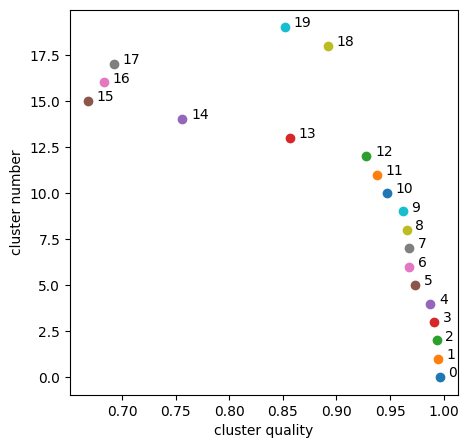

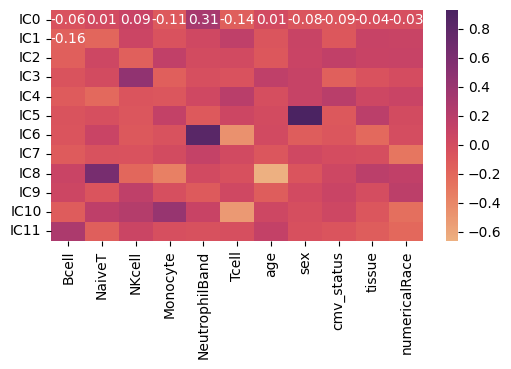

In [11]:
test = Icasso(iterations= 10, n_components = 20)
test.icassoEst(meth_data = methRaw)
test.icassoExp(sign= 0)
# # test.icassoDendrogram()
unmixing, scores, unstable_components = test.get_centrotype_unmixing(distance= .65, unstable_thresh= .93)


stable_IC = test._trait_correlation(traits,methRaw, unstable_components)

print("stabel IC shape ", stable_IC.shape)

unmixing = test._get_stable_unmixing(unstable_components)

site_dic, site_names = test._site_contribution(unmixing, component = 8, influence_thresh = 0.002, sign= 1)





In [12]:
print(len(site_names))

107


ICA Lasso
Bcell
MAE: 0.063 (0.051)
R^2:  -0.006989655013110108
NaiveT
MAE: 0.060 (0.047)
R^2:  0.4219964316147632
NKcell
MAE: 0.052 (0.049)
R^2:  0.2522833202570711
Monocyte
MAE: 0.093 (0.064)
R^2:  0.2967941131416365
NeutrophilBand
MAE: 0.041 (0.037)
R^2:  0.7905157170518097
Tcell
MAE: 0.103 (0.086)
R^2:  0.42828132786782347
age
MAE: 7.497 (5.512)
R^2:  0.4631358761540044
sex
MAE: 0.104 (0.099)
R^2:  0.9178370561986252
cmv_status
MAE: 0.458 (0.149)
R^2:  -0.005559632432621253
tissue
MAE: 0.465 (0.138)
R^2:  0.04588251624952833
numericalRace
MAE: 1.239 (0.575)
R^2:  0.17556413553487193


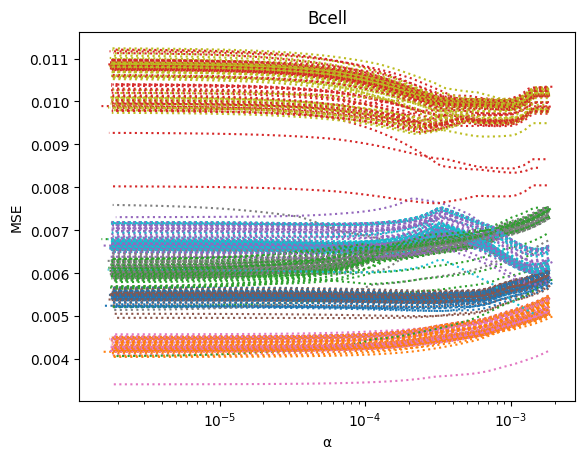

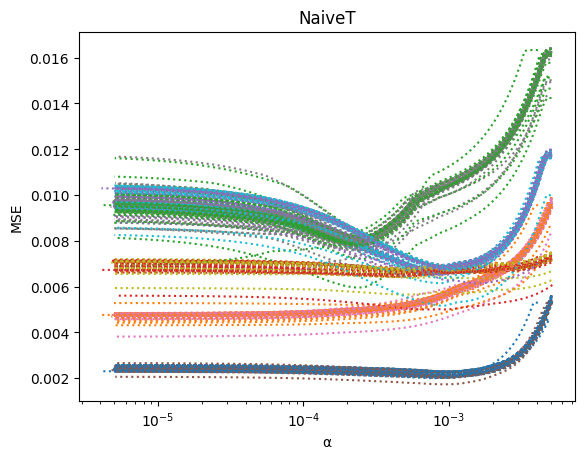

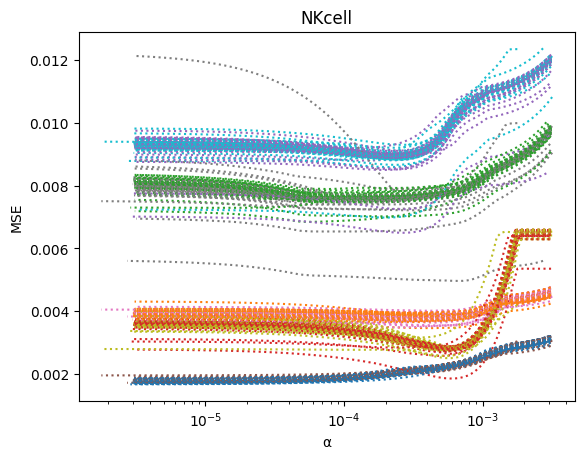

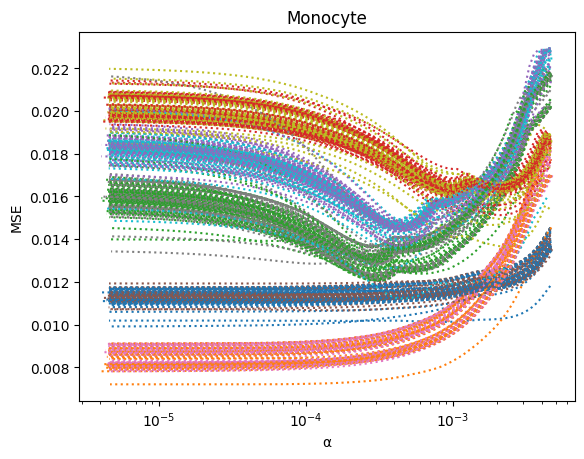

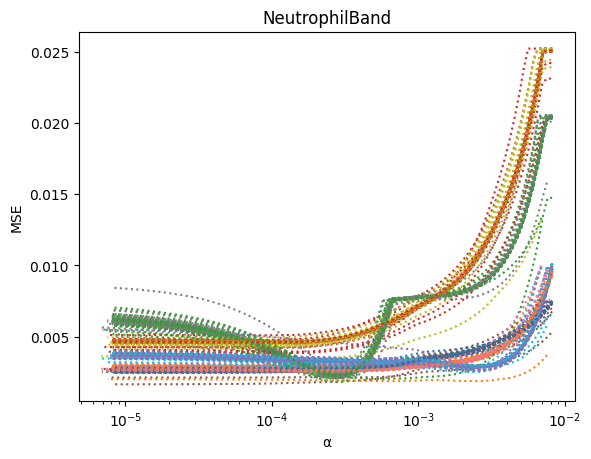

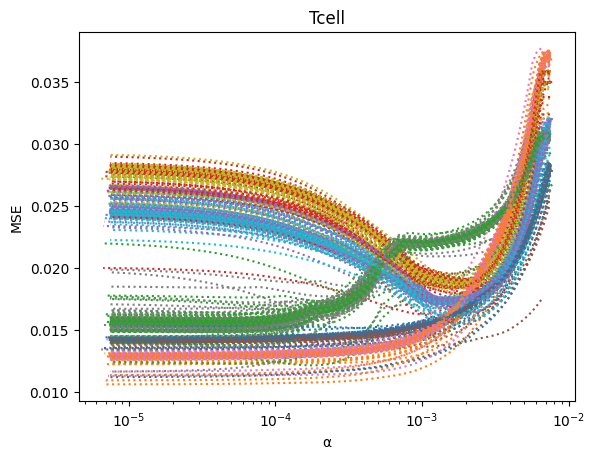

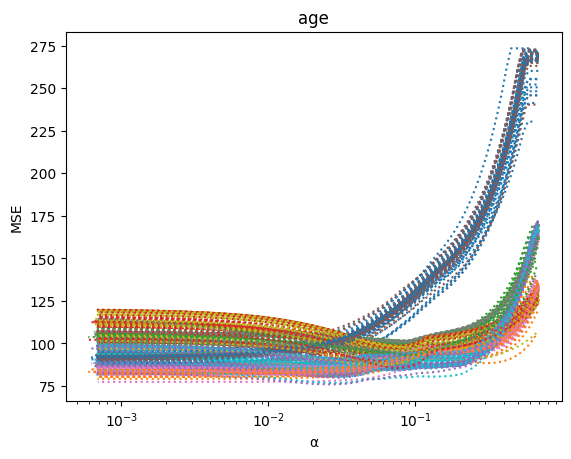

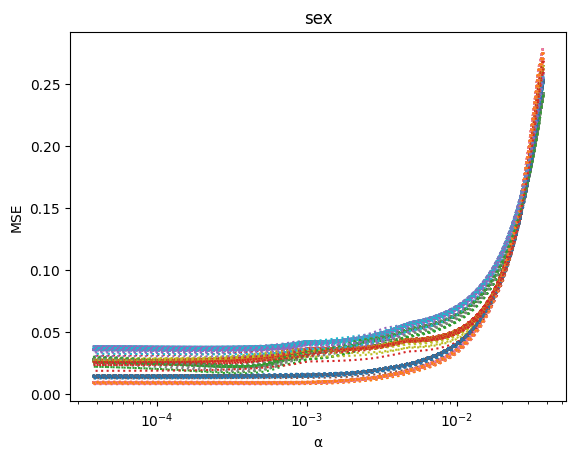

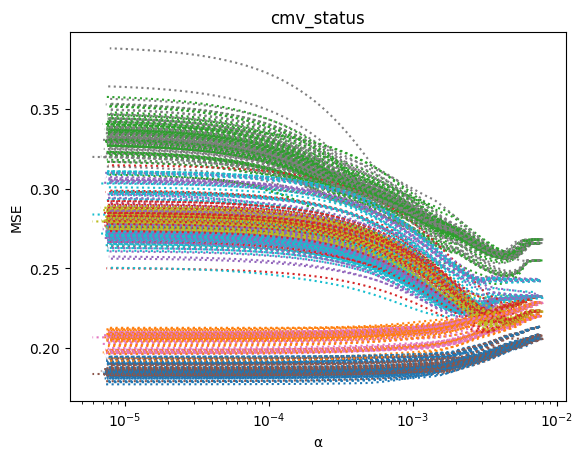

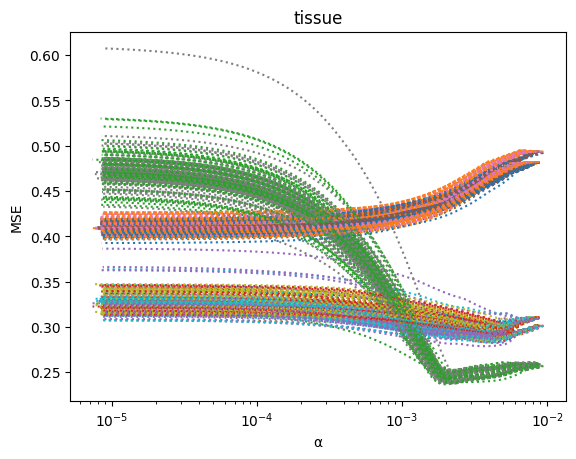

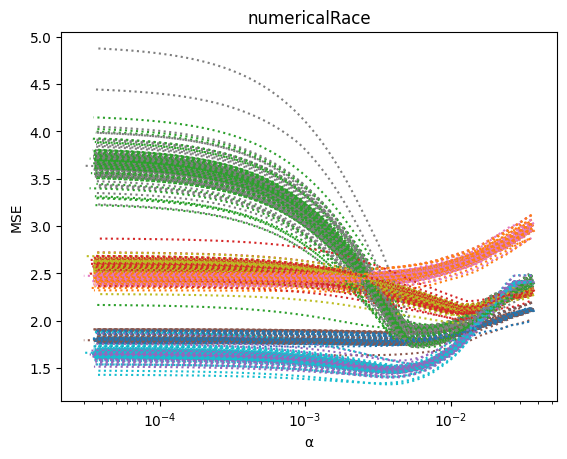

In [13]:

#lasso model implementation

#trim out y response. test on neutrophils
r_sq_list = []


# My original code that sucks

# for i in traits:
#     y_temp = traits[i]
#     y_temp = pd.DataFrame(y_temp).to_numpy()
#     y_train = np.ravel(y_temp)
#     X_train = pd.DataFrame(stable_IC).to_numpy()
    
#     r_sq_list.append(regression_model(X_train, y_train))



print("ICA Lasso")
for i in traits:
    y_trait = traits[i]
    X_train = pd.DataFrame(stable_IC)
    
    print(i)
    
    r_sq_list.append(regression_model(X_train, y_trait, i))


# print("list of R^2")
# print(r_sq_list)
# print("trait list")
# print(traits.columns)

# plt.figure(figsize= (5,5))

# plt.scatter(r_sq_list, traits.columns)

# for j in range(0,len(r_sq_list)):
#     plt.annotate(text= round(r_sq_list[j], 3),xy = (r_sq_list[j], j), xytext = (r_sq_list[j]+.01, j+.015))

# r_sq_list= pd.DataFrame(r_sq_list)
# r_sq_list = r_sq_list.T

# r_sq_list.columns = traits.columns


# print("r_sq_list")
# r_sq_list.head()










In [14]:
# _make_bed(site_names)

In [15]:
comparisonDF = pd.read_csv('/Users/AdrianHanson/Desktop/ICA_comparison.csv', index_col=0)

In [16]:
display(comparisonDF)

Bcell    NaiveT    NKcell  Monocyte  NeutrophilBand     Tcell  \
ICA MAE   0.063000  0.060000  0.052000  0.093000        0.041000  0.103000   
PCA MAE   0.025000  0.045000  0.036000  0.063000        0.050000  0.072000   
PLS MAE   0.025000  0.041000  0.032000  0.051000        0.037000  0.069000   
ICA R^2   0.006990  0.421996  0.252283  0.296794        0.790516  0.428281   
PCA R^2   0.848165  0.659882  0.627650  0.639159        0.652343  0.741319   
PLS R^2   0.843143  0.704892  0.709477  0.754154        0.820905  0.748043   
NaN            NaN       NaN       NaN       NaN             NaN       NaN   

               age       sex  cmv_status    tissue  numericalRace  
ICA MAE   7.497000  0.104000    0.458000  0.465000       1.239000  
PCA MAE   6.180000  0.131000    0.455000  0.133000       1.172000  
PLS MAE   3.899000  0.136000    0.382000  0.137000       1.048000  
ICA R^2   0.463136  0.917837    0.005560  0.045883       0.175564  
PCA R^2   0.517871  0.896794    0.016120  0.782205       0.213980  
PLS R^2   0.850824  0.909193    0.147875  0.896385       0.344392  
NaN            NaN       NaN         NaN       NaN            NaN